https://www.tensorflow.org/tutorials/images/segmentation

In [1]:
# !pip uninstall keras
# !pip install keras==2.1.5

import keras
keras.__version__

Using TensorFlow backend.


'2.1.5'

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


copied and edited from: \
https://github.com/YBIGTA/data-science-2018/blob/master/DLCV/2018-02-10-Keras-U-Net-starter.md

In [0]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K


import tensorflow as tf

from numpy import expand_dims
from tensorflow.keras.datasets import mnist

# from tensorflow.python.keras import backend


(x_train, y_train), (_, _) = mnist.load_data()
X = expand_dims(x_train, axis=-1)

ids, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = X.shape  # (60000, 28, 28, 1)

X = X.astype('float32')
X = X / 255.0



# mnist (output)
# normal = X[1000:2000]
normal = X[:1000]

# 줄 낙서 (input)
X_anomal = X[1000:2000]
X_anomal[:, 15, 2:10] = 1.0
X_anomal[:, 2:19, 7] = 1.0
ruined = X_anomal


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

# Get train and test IDs
normal_ids = normal.shape[0]
ruined_ids = ruined.shape[0]

In [0]:
# convert class vectors to binary class matrices

y_train = X[2000:3000]
y_train[:, 15, 2:10] = 1.0
y_train[:, 2:19, 7] = 1.0

y_test = X[3000:4000]

In [0]:
# # Get and resize train images and masks
# # X_train = np.zeros((len(normal_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_train = np.zeros((len(normal_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
# print('Getting and resizing train images and masks ... ')
# sys.stdout.flush()
# for n, id_ in tqdm(enumerate(normal_ids), total=len(normal_ids)):
#     path = TRAIN_PATH + id_
#     img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_train[n] = img
#     mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
#     for mask_file in next(os.walk(path + '/masks/'))[2]:
#         mask_ = imread(path + '/masks/' + mask_file)
#         mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                                       preserve_range=True), axis=-1)
#         mask = np.maximum(mask, mask_)
#     Y_train[n] = mask

# # Get and resize test images
# X_test = np.zeros((len(ruined_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# sizes_test = []
# print('\nGetting and resizing test images ... ')
# sys.stdout.flush()
# for n, id_ in tqdm(enumerate(ruined_ids), total=len(ruinde_ids)):
#     path = TEST_PATH + id_
#     img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
#     sizes_test.append([img.shape[0], img.shape[1]])
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_test[n] = img

# print('\nDone!')

In [3]:
print(normal_ids)

1000


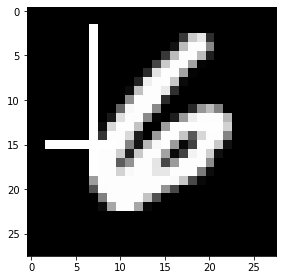

In [10]:
# Check if training data looks all right
ix = random.randint(0, normal_ids)
imshow(normal[ix].reshape(28,28))
plt.show()

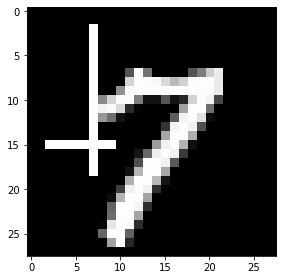

In [6]:
imshow(ruined[ix].reshape(28,28))
plt.show()

In [0]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [6]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

# 3 peak (1, 2까지만 maxpooling)
# 6 - 2
# 7 - 1

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)


c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

# peak
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)


u4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c3)
u4 = concatenate([u4, c2])
c4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)


u5 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c1], axis=3)
c5 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u5)
c5 = Dropout(0.2) (c5)
c5 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)


outputs = Conv2D(1, (1, 1), activation='sigmoid') (c5)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   160         lambda[0][0]           

In [9]:
earlystopper = EarlyStopping(patience=5, verbose=1)
# checkpointer = ModelCheckpoint('model-2020-1.h5', verbose=1, save_best_only=True)
checkpointer = ModelCheckpoint(filepath = 'model_2020_05.hdf5', verbose=1, save_best_only=True, save_weights_only = True)

model.fit(ruined, normal
          , validation_split=0.1
          , batch_size=16
          , epochs=50
          , callbacks=[checkpointer, earlystopper])


model.save('my_model.h5')
score = model.evaluate(y_train, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 900 samples, validate on 100 samples
Epoch 1/50
896/900 [============================>.] - ETA: 0s - loss: 0.2606 - mean_iou: 0.4979
Epoch 00001: val_loss improved from inf to 0.26633, saving model to model_2020_05.hdf5
900/900 [==============================] - 1s 1ms/sample - loss: 0.2605 - mean_iou: 0.4979 - val_loss: 0.2663 - val_mean_iou: 0.4979
Epoch 2/50
896/900 [============================>.] - ETA: 0s - loss: 0.2606 - mean_iou: 0.4979
Epoch 00002: val_loss improved from 0.26633 to 0.26341, saving model to model_2020_05.hdf5
900/900 [==============================] - 1s 1ms/sample - loss: 0.2606 - mean_iou: 0.4979 - val_loss: 0.2634 - val_mean_iou: 0.4979
Epoch 3/50
848/900 [===========================>..] - ETA: 0s - loss: 0.2600 - mean_iou: 0.4979
Epoch 00003: val_loss improved from 0.26341 to 0.26312, saving model to model_2020_05.hdf5
900/900 [==============================] - 1s 1ms/sample - loss: 0.2599 - mean_iou: 0.4979 - val_loss: 0.2631 - val_mean_iou: 0.497

1000/1000 [==============================] - 0s 68us/sample


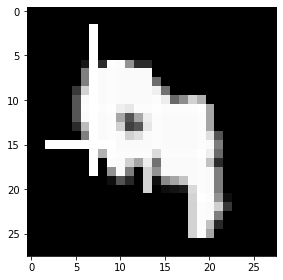

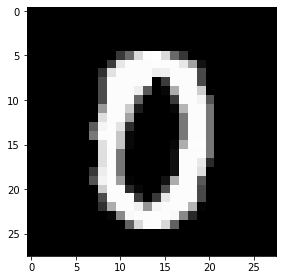

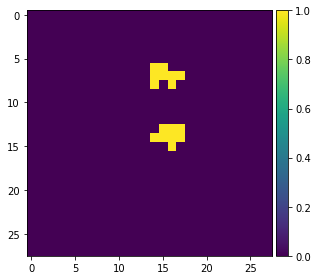

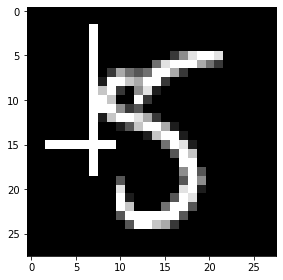

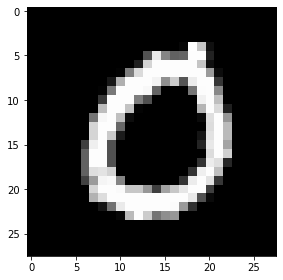

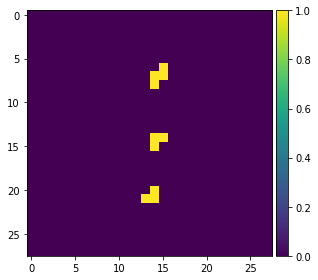

In [13]:
# Predict on train, val and test
# model = load_model('model-dsbowl2020-1.h5', custom_objects={'mean_iou': mean_iou})
model = load_model('my_model.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(ruined[:int(ruined.shape[0]*0.9)], verbose=1)
preds_val = model.predict(y_train[int(y_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(normal, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
# preds_test_upsampled = []
# for i in range(len(preds_test)):
#     preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
#                                        (sizes_test[i][0], sizes_test[i][1]), 
#                                        mode='constant', preserve_range=True))


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(ruined[ix].reshape(28, 28))
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(ruined[int(ruined.shape[0]*0.9):][ix].reshape(28, 28))
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [0]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)


new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)